In [1]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator
from trace_IO import *
from OF_trigger import *

import matplotlib.pyplot as plt

def plot_trace_set(trace_set, offset=50):
    """
    Plot a single trace set (shape: 54 x N) with vertical offsets.

    Parameters:
    - trace_set: ndarray, shape (54, N)
    - offset: float, vertical offset between channels
    """
    n_channels, n_samples = trace_set.shape

    for i in range(n_channels):
        color = 'r' if i > 44 else 'b'
        plt.plot(np.arange(n_samples), trace_set[i] + i * offset, color=color, lw=0.2)

    plt.xlabel("Sample Index")
    plt.yticks([])
    plt.ylim(-10, offset * n_channels)
    plt.title("Trace Set")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('../archive/config.yaml')
ts = TraceSimulator(config)

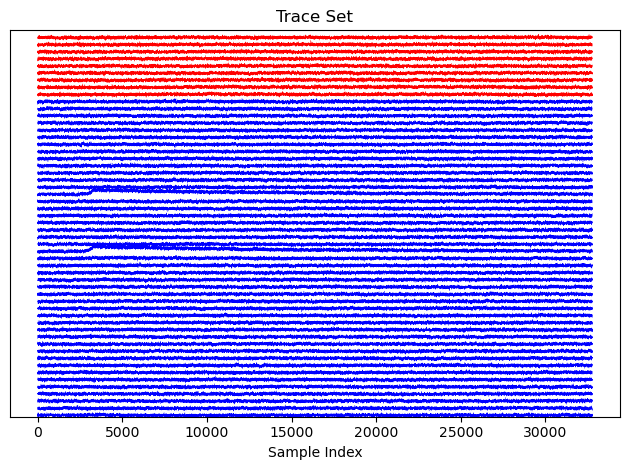

In [11]:
trace = ts.generate(E=100, x=-40, y=80, z=-1800, no_noise=False, type_recoil='ER', quantize=True, phonon_only=False)
plot_trace_set(trace[0])

In [5]:
sampling_frequency = 3906250
template = np.load("../templates/template_K_alpha_no_baseline.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")
sum_psd = np.load("../templates/sum_ch/noise_psd_from_MMC_sum45.npy")

# Initialize Optimum Filter
trigger_ind = OFtrigger(template, noise_psd, sampling_frequency)
trigger_sum = OFtrigger(template, sum_psd, sampling_frequency)

In [12]:
# Initialize lists to hold fit results
amplitudes = []
chi2s = []
t0s = []

# Loop over all 54 channels
for i in range(54):
    ampl, chi2, t0 = trigger_ind.fit_with_shift(trace[0][i])
    amplitudes.append(ampl)
    chi2s.append(chi2)
    t0s.append(t0)
    print(f"Trace {i}: Amplitude = {ampl:.4f}, Chi2 = {chi2:.4f}, t0 = {t0:.4f}")

# Optionally convert to NumPy arrays
import numpy as np
amplitudes = np.array(amplitudes)
chi2s = np.array(chi2s)
t0s = np.array(t0s)



Trace 0: Amplitude = -2.5361, Chi2 = 0.2181, t0 = 782.0000
Trace 1: Amplitude = -1.5291, Chi2 = 0.2176, t0 = -1528.0000
Trace 2: Amplitude = -2.0819, Chi2 = 0.2175, t0 = 1429.0000
Trace 3: Amplitude = 0.9145, Chi2 = 0.2176, t0 = -1459.0000
Trace 4: Amplitude = -1.7692, Chi2 = 0.2176, t0 = -383.0000
Trace 5: Amplitude = -1.3061, Chi2 = 0.2171, t0 = 1069.0000
Trace 6: Amplitude = -1.7985, Chi2 = 0.2179, t0 = 1755.0000
Trace 7: Amplitude = -1.5023, Chi2 = 0.2175, t0 = 1553.0000
Trace 8: Amplitude = 1.8091, Chi2 = 0.2176, t0 = 829.0000
Trace 9: Amplitude = 1.5042, Chi2 = 0.2178, t0 = -1061.0000
Trace 10: Amplitude = 1.4116, Chi2 = 0.2178, t0 = 133.0000
Trace 11: Amplitude = -2.1840, Chi2 = 0.2176, t0 = 1795.0000
Trace 12: Amplitude = 1.3641, Chi2 = 0.2172, t0 = 1079.0000
Trace 13: Amplitude = 2.5287, Chi2 = 0.2176, t0 = 777.0000
Trace 14: Amplitude = 1.9357, Chi2 = 0.2170, t0 = -1275.0000
Trace 15: Amplitude = 1.2650, Chi2 = 0.2176, t0 = 658.0000
Trace 16: Amplitude = 1.2713, Chi2 = 0.2174

In [13]:
import numpy as np

# Sum all 54 channels along axis 0 (over the 32768 samples)
summed_trace = np.sum(trace[0][:45], axis=0)

# Apply optimal filter fitting to the summed trace
ampl, chi2, t0 = trigger_sum.fit_with_shift(summed_trace)


In [14]:
ampl

63.932982149852286

In [15]:
t0

-1096

In [51]:
chi2

9.918378942880091

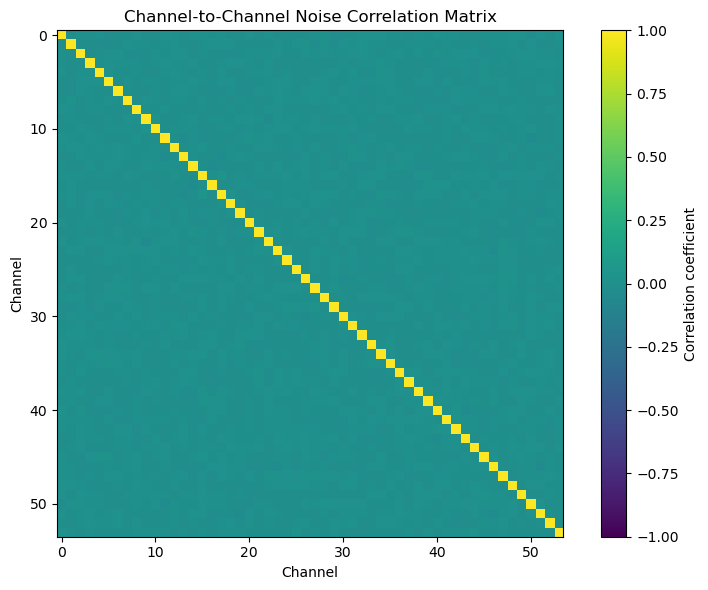

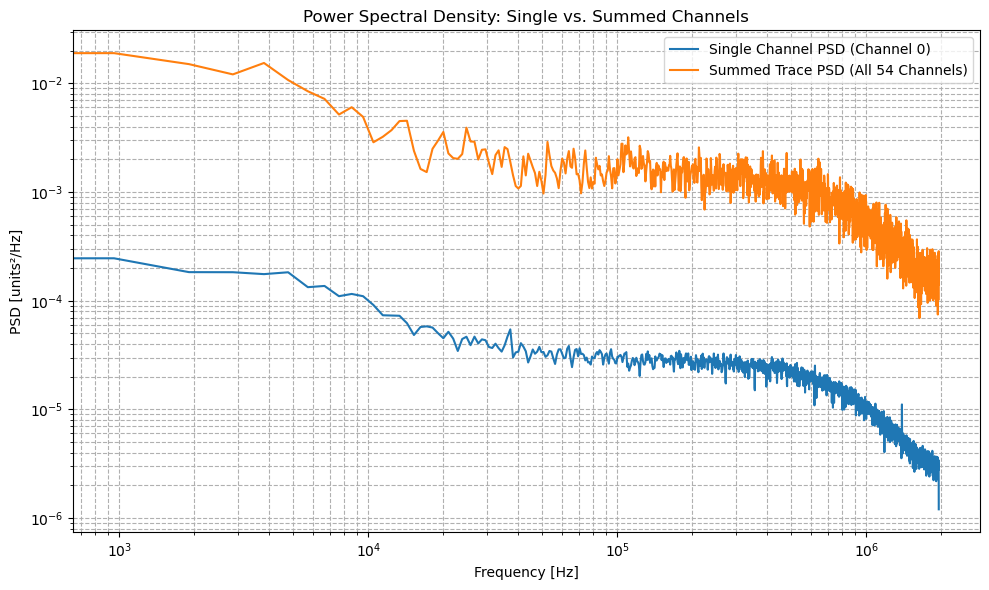

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Assume `trace` is your input array with shape (1, 54, 32768)
trace_noise = trace[0]  # shape (54, 32768)

# 1. Correlation matrix across channels
# Flatten time axis and compute correlation
corr_matrix = np.corrcoef(trace_noise)

# Plot correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Correlation coefficient')
plt.title('Channel-to-Channel Noise Correlation Matrix')
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.tight_layout()
plt.show()

# 2. Compute PSD of one channel and the summed trace
fs = 3906250  # sampling frequency (set to real value if known)
f, psd_one = welch(trace_noise[0], fs=fs, nperseg=4096)
_, psd_sum = welch(np.sum(trace_noise, axis=0), fs=fs, nperseg=4096)

# 3. Plot PSD comparison
plt.figure(figsize=(10, 6))
plt.loglog(f, psd_one, label='Single Channel PSD (Channel 0)')
plt.loglog(f, psd_sum, label='Summed Trace PSD (All 54 Channels)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [units²/Hz]')
plt.title('Power Spectral Density: Single vs. Summed Channels')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


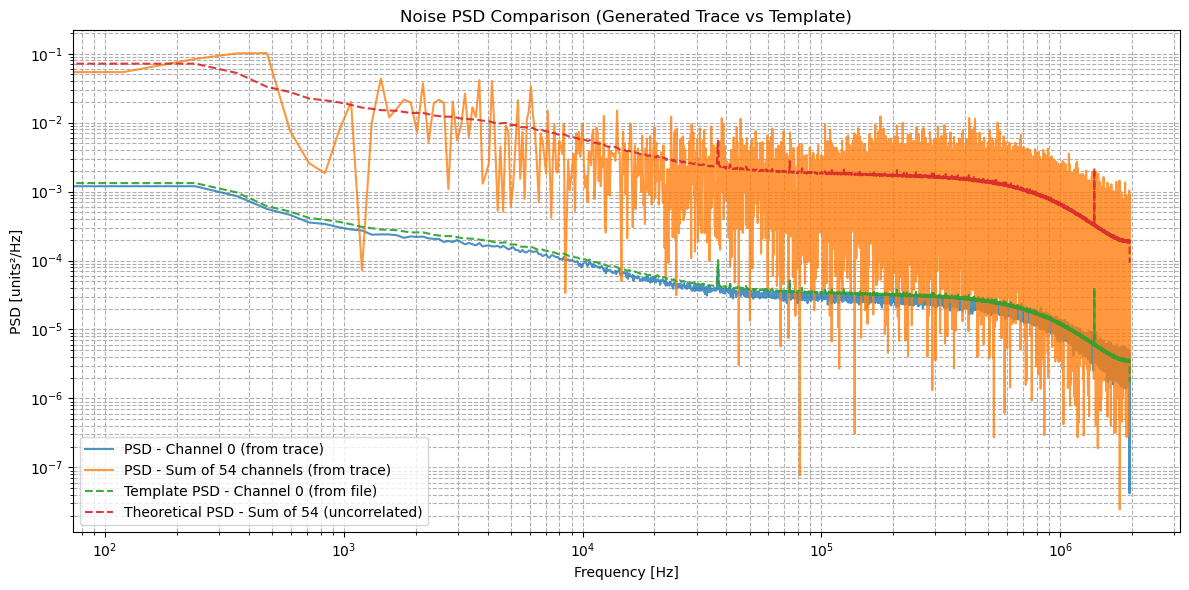

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq

# -------------------------
# 1. Generate Noise Trace
# -------------------------
trace = ts.generate(
    E=0, x=-40, y=80, z=-1800,
    no_noise=False, type_recoil='ER',
    quantize=True, phonon_only=False
)  # shape: (1, 54, 32768)

trace_noise = trace[0]  # shape: (54, 32768)

# -------------------------
# 2. PSD Calculation Function
# -------------------------
def calculate_psd(traces, sampling_frequency=1.0):
    norm = sampling_frequency * traces.shape[-1]
    if len(traces.shape) == 1:
        psd = (np.abs(rfft(traces)) ** 2.0) / norm
    else:
        psd = np.mean(np.abs(rfft(traces)) ** 2.0, axis=0) / norm
    psd[1:traces.shape[-1]//2 + 1 - (traces.shape[-1] + 1) % 2] *= 2.0
    f = rfftfreq(traces.shape[-1], d=1.0 / sampling_frequency)
    return f, psd

# -------------------------
# 3. Load Template PSD (Shape = 16385)
# -------------------------
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")
assert noise_psd.shape == (16385,), "Expected shape (16385,) for noise_psd"

# -------------------------
# 4. Compute PSDs
# -------------------------
fs = 3906250  # 3.90625 MHz sampling frequency

f, psd_ch0 = calculate_psd(trace_noise[0], sampling_frequency=fs)
_, psd_sum = calculate_psd(np.sum(trace_noise, axis=0), sampling_frequency=fs)
psd_theoretical_sum = 54 * noise_psd  # Assuming uncorrelated noise

# -------------------------
# 5. Plotting
# -------------------------
plt.figure(figsize=(12, 6))
plt.loglog(f, psd_ch0, label='PSD - Channel 0 (from trace)', alpha=0.8)
plt.loglog(f, psd_sum, label='PSD - Sum of 54 channels (from trace)', alpha=0.8)
plt.loglog(f, noise_psd, '--', label='Template PSD - Channel 0 (from file)', alpha=0.9)
plt.loglog(f, psd_theoretical_sum, '--', label='Theoretical PSD - Sum of 54 (uncorrelated)', alpha=0.9)

plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [units²/Hz]')
plt.title('Noise PSD Comparison (Generated Trace vs Template)')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


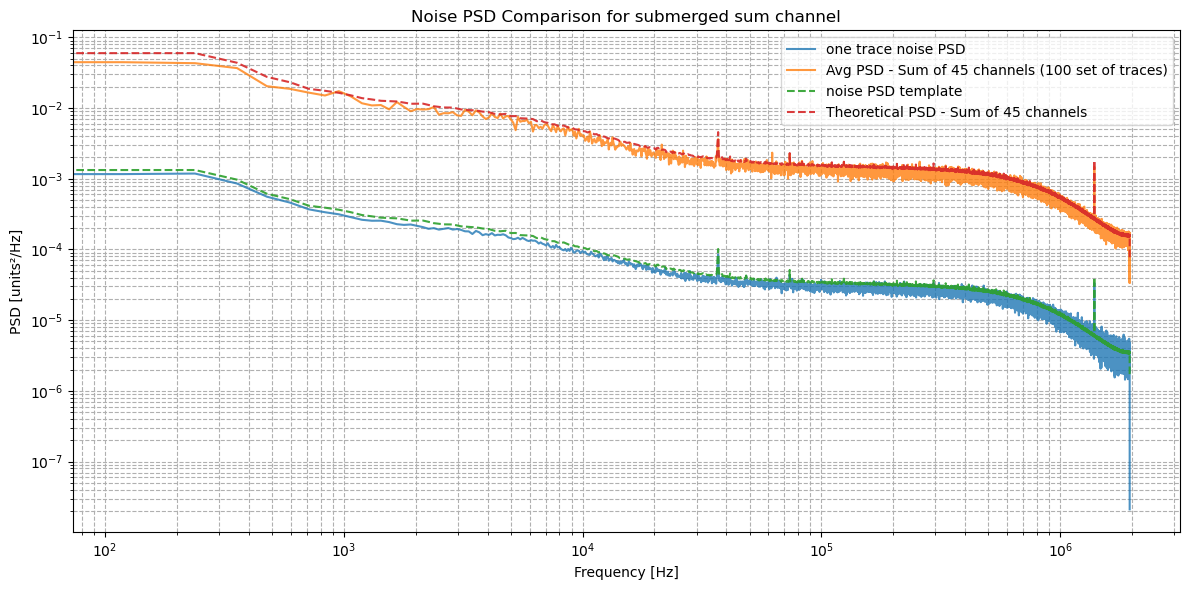

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq

# -------------------------
# 1. Generate 100 Noise Traces
# -------------------------
num_traces = 100
channel_subset = 45

all_traces = np.array([
    ts.generate(E=0, x=-40, y=80, z=-1800, no_noise=False, type_recoil='ER',
                quantize=True, phonon_only=False)[0][:channel_subset]
    for _ in range(num_traces)
])  # shape: (100, 45, 32768)

# -------------------------
# 2. PSD Calculation Function
# -------------------------
def calculate_psd(traces, sampling_frequency=1.0):
    norm = sampling_frequency * traces.shape[-1]
    if len(traces.shape) == 1:
        psd = (np.abs(rfft(traces)) ** 2.0) / norm
    else:
        psd = np.mean(np.abs(rfft(traces)) ** 2.0, axis=0) / norm
    psd[1:traces.shape[-1]//2 + 1 - (traces.shape[-1] + 1) % 2] *= 2.0
    f = rfftfreq(traces.shape[-1], d=1.0 / sampling_frequency)
    return f, psd

# -------------------------
# 3. Load Template PSD (Shape = 16385)
# -------------------------
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")
assert noise_psd.shape == (16385,), "Expected shape (16385,) for noise_psd"

# -------------------------
# 4. Compute PSDs
# -------------------------
fs = 3906250  # 3.90625 MHz

# Single trace from first channel of first sample
f, psd_ch0 = calculate_psd(all_traces[0, 0], sampling_frequency=fs)

# Sum first 45 channels for each trace → shape: (100, 32768)
sum_signals = np.sum(all_traces, axis=1)

# Compute PSD for each summed signal
psds = np.array([
    calculate_psd(trace, sampling_frequency=fs)[1] for trace in sum_signals
])  # shape: (100, 16385)

# Average PSD across 100 summed traces
psd_sum_avg = np.mean(psds, axis=0)

# Theoretical PSD assuming uncorrelated noise summed over 45 channels
psd_theoretical_sum = channel_subset * noise_psd

# -------------------------
# 5. Plotting
# -------------------------
plt.figure(figsize=(12, 6))
plt.loglog(f, psd_ch0, label='one trace noise PSD', alpha=0.8)
plt.loglog(f, psd_sum_avg, label='Avg PSD - Sum of 45 channels (100 set of traces)', alpha=0.8)
plt.loglog(f, noise_psd, '--', label='noise PSD template', alpha=0.9)
plt.loglog(f, psd_theoretical_sum, '--', label='Theoretical PSD - Sum of 45 channels', alpha=0.9)

plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [units²/Hz]')
plt.title('Noise PSD Comparison for submerged sum channel')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


In [7]:
import numpy as np

# Load the single-channel noise PSD
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")  # shape (16385,)
assert noise_psd.shape == (16385,), "Expected shape (16385,) for noise_psd"

# Number of uncorrelated channels
channel_subset = 45

# Compute theoretical summed PSD
psd_theoretical_sum = channel_subset * noise_psd

# Save to file
output_path = "../templates/sum_ch/noise_psd_from_MMC_sum45.npy"
np.save(output_path, psd_theoretical_sum)

print(f"Theoretical 45-channel PSD saved to: {output_path}")


Theoretical 45-channel PSD saved to: ../templates/sum_ch/noise_psd_from_MMC_sum45.npy
